# Calcular población en cada cuadrante de la CDMX
### Gerardo Mathus
### Propedeútico de la Maestría en Ciencia de Datos
#### 14 de julio de 2019
---
##### La Estrategia de Proximidad de Cuadrantes de la Secretaría de Seguridad Ciudadana creó esta delimitación territorial de 847 cuadrantes. Los datos se pueden consultar en [Datos CDMX Cuadrantes](https://datos.cdmx.gob.mx/explore/dataset/cuadrantes/information/) en mapas y tablas. Ahí mismo se encuentran las ligas de descarga, así como un API público que no me di el tiempo de explorar, pero seguro es más útil que descargar los datos.
---
###### El objetivo en este notebook es trabajar con `geopandas` para crear un nuevo dataset que contenga la población en cada cuadrante de la CDMX. Se pretende hacer lo siguiente:
1. Leer el shapefile de cuadrantes
2. Leer el shapefile de manzanas de la CDMX son del [Marco Geoestadístico del Censo de Población y Viviendo 2010 del INEGI](https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=702825296520). Estas manzanas tienen datos de **población**
3. Calcular el centroide de cada polígono de la manzana.
4. Hacer un join espacial de los polígonos de los cuadrantes con el centroide del polígono de la manzana
5. Crear una nueva agregación que contenga los cuadrantes con la suma de las poblaciones de las manzanas que están dentor de ese polígono.
6. Guardar el archivo a un nuevo shapefile para que se pueda usar en otros scripts o para que lo use alguien más

#### Agradecimiento a [Diego Valle Jones](https://www.diegovalle.net/) por simplificar muchos datos y por ayudarme a comprender su metodología

In [110]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [60]:
#leer cuadrantes que descargamos de datos.cdmx.gob.mx
cuadrantes = gpd.read_file('data/cuadrantes/cuadrantes.shp')
cuadrantes = cuadrantes[cuadrantes.geometry.notnull()] #hay un cuadrante en VENUSTIANO CARRANZA que no tiene geometría 

In [61]:
#leer manzanas del marco geoestadístico
manzanas = gpd.read_file('../df/df_manzanas.shp')

In [62]:
cuadrantes.head()

,nomenclatu,cve_zona,deleg,no_region,no_cuadran,zona,cve_sector,sector,x,y,geometry
0,N-1.2.2,N,GUSTAVO A MADERO,1.0,2.0,NORTE,2,CUAUTEPEC,-99.137705,19.565990,"POLYGON ((-99.1311281738739 19.57075324294661,..."
1,C-1.4.17,C,CUAUHTEMOC,1.0,17.0,CENTRO,4,BUENAVISTA,-99.141425,19.440934,"POLYGON ((-99.14379617387391 19.4399732429466,..."
2,N-1.2.9,N,GUSTAVO A MADERO,1.0,9.0,NORTE,2,CUAUTEPEC,-99.132634,19.556968,POLYGON ((-99.13642417387391 19.55785624294661...
3,C-1.2.15,C,CUAUHTEMOC,1.0,15.0,CENTRO,2,ANGEL,-99.166388,19.429223,POLYGON ((-99.16978917387389 19.43100624294661...
4,N-3.2.5,N,VENUSTIANO CARRANZA,3.0,5.0,NORTE,2,CONGRESO,-99.114289,19.429374,"POLYGON ((-99.1196181738739 19.42769624294661,..."


In [63]:
manzanas.head()

,CVEGEO,POB1,POB2,POB2_R,POB3,POB3_R,POB4,POB4_R,POB5,POB5_R,...,POB78,POB78_R,POB79,POB79_R,POB80,POB80_R,POB81,POB81_R,OID,geometry
0,0900200010542046,1,-6,-6.0,-6,-6.0,-6,-6.0,-6,-6.0,...,-6,-6.0,-6,-6.0,-6,-6.0,-6,-6.0,1,POLYGON ((-99.16225592498134 19.47032642626956...
1,0900200010542047,0,0,-8.0,0,-8.0,0,-8.0,0,-8.0,...,0,-8.0,0,-8.0,0,-8.0,0,-8.0,2,POLYGON ((-99.16229872168441 19.47059276905692...
2,0900200010542048,17,0,0.0,-6,-6.0,-6,-6.0,0,0.0,...,6,60.0,0,0.0,0,0.0,0,0.0,3,POLYGON ((-99.16212524954102 19.47094501779506...
3,0900200010542050,4,-6,-6.0,-6,-6.0,-6,-6.0,-6,-6.0,...,-6,-6.0,-6,-6.0,-6,-6.0,-6,-6.0,4,POLYGON ((-99.16241471250828 19.47126871424026...
4,0900200010542049,0,0,-8.0,0,-8.0,0,-8.0,0,-8.0,...,0,-8.0,0,-8.0,0,-8.0,0,-8.0,5,POLYGON ((-99.16226191709934 19.47111167065794...


##### Como podemos ver, el shapefile sirve también como dataframe, pero tiene también atributos de geometría. Mismos que podemos utilizar para análisis geoespacial. Todo geodataframe debe tener una serie  `geometry` que dicte el polígono, punto, línea, etc., de éste.

---
### Shapefile plot

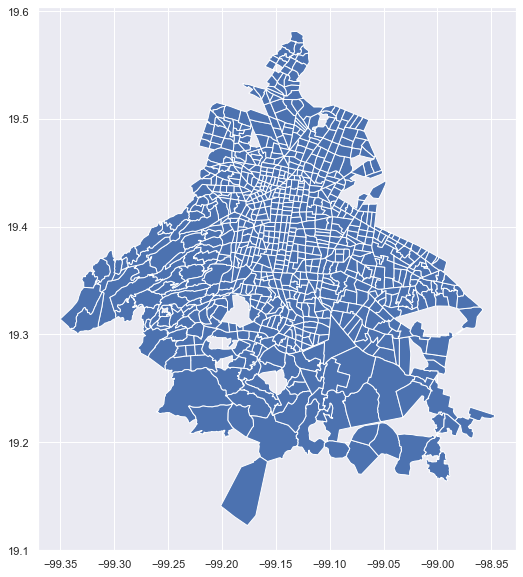

In [111]:
plt.rcParams['figure.figsize'] = [10, 10]
cuadrantes.plot()

In [4]:
crs = {"init":"epsg:4326"}  # sistema de coordenadas

In [66]:
#Crear un nuevo GeoDataFrame que contenga únicamente CVEGEO, geometría y población
manzanas_simple = gpd.GeoDataFrame(manzanas[['CVEGEO','POB1','geometry']], crs=crs)

In [67]:
manzanas_simple.head()

,CVEGEO,POB1,geometry
0,0900200010542046,1,POLYGON ((-99.16225592498134 19.47032642626956...
1,0900200010542047,0,POLYGON ((-99.16229872168441 19.47059276905692...
2,0900200010542048,17,POLYGON ((-99.16212524954102 19.47094501779506...
3,0900200010542050,4,POLYGON ((-99.16241471250828 19.47126871424026...
4,0900200010542049,0,POLYGON ((-99.16226191709934 19.47111167065794...


In [68]:
#crear columna de centroide para la manzana
manzanas_simple['centroide'] = manzanas_simple.geometry.centroid

In [69]:
manzanas_simple.head()

,CVEGEO,POB1,geometry,centroide
0,0900200010542046,1,POLYGON ((-99.16225592498134 19.47032642626956...,POINT (-99.16204179906643 19.47033977828303)
1,0900200010542047,0,POLYGON ((-99.16229872168441 19.47059276905692...,POINT (-99.16212914134192 19.47061751034639)
2,0900200010542048,17,POLYGON ((-99.16212524954102 19.47094501779506...,POINT (-99.16225329764345 19.47081706820799)
3,0900200010542050,4,POLYGON ((-99.16241471250828 19.47126871424026...,POINT (-99.16251367073754 19.47114331722368)
4,0900200010542049,0,POLYGON ((-99.16226191709934 19.47111167065794...,POINT (-99.16238455390963 19.47098598468774)


#### Vamos ahora a eliminar la columna de geometry de `manzanas simple` y renombrar `centroide` a `geometry` para que podamos hacer un join espacial de manzanas con cuadrantes. Esta operación buscará en ambos geodataframes los valores de geometría, y por eso es importante tener solo uno.

In [74]:
manzanas_simple = manzanas_simple.drop(['geometry'], axis=1)
manzanas_simple.head()

,CVEGEO,POB1,centroide
0,0900200010542046,1,POINT (-99.16204179906643 19.47033977828303)
1,0900200010542047,0,POINT (-99.16212914134192 19.47061751034639)
2,0900200010542048,17,POINT (-99.16225329764345 19.47081706820799)
3,0900200010542050,4,POINT (-99.16251367073754 19.47114331722368)
4,0900200010542049,0,POINT (-99.16238455390963 19.47098598468774)


In [75]:
#renombrar columnas
manzanas_simple.columns = ('CVEGEO', 'POB1','geometry')

In [76]:
manzanas_en_cuadrantes = gpd.sjoin(cuadrantes, manzanas_simple, op='contains')

In [77]:
manzanas_en_cuadrantes.head()

,nomenclatu,cve_zona,deleg,no_region,no_cuadran,zona,cve_sector,sector,x,y,geometry,index_right,CVEGEO,POB1
0,N-1.2.2,N,GUSTAVO A MADERO,1.0,2.0,NORTE,2,CUAUTEPEC,-99.137705,19.56599,"POLYGON ((-99.1311281738739 19.57075324294661,...",15544,0900500013445034,250
0,N-1.2.2,N,GUSTAVO A MADERO,1.0,2.0,NORTE,2,CUAUTEPEC,-99.137705,19.56599,"POLYGON ((-99.1311281738739 19.57075324294661,...",16063,0900500012593006,39
0,N-1.2.2,N,GUSTAVO A MADERO,1.0,2.0,NORTE,2,CUAUTEPEC,-99.137705,19.56599,"POLYGON ((-99.1311281738739 19.57075324294661,...",16058,0900500012593033,62
0,N-1.2.2,N,GUSTAVO A MADERO,1.0,2.0,NORTE,2,CUAUTEPEC,-99.137705,19.56599,"POLYGON ((-99.1311281738739 19.57075324294661,...",10377,0900500012593004,249
0,N-1.2.2,N,GUSTAVO A MADERO,1.0,2.0,NORTE,2,CUAUTEPEC,-99.137705,19.56599,"POLYGON ((-99.1311281738739 19.57075324294661,...",16065,0900500012593015,164


In [82]:
#extrar un dataframe que tenga unicamente la nomenclatura (identificador) del cuadrante
#y la población sumada después de agrupar por nomenclatura
cuadrante_poblacion  =  manzanas_en_cuadrantes.groupby('nomenclatu').agg('sum').reset_index()[['nomenclatu', 'POB1']]
cuadrante_poblacion.head()

,nomenclatu,POB1
0,C-1.1.1,36
1,C-1.1.2,729
2,C-1.1.3,811
3,C-1.1.4,4116
4,C-1.1.5,2228


In [83]:
#hacemos merge del archivo inicial de cuadrantes con este frame pequeño quetiene nomenclatu y población
cuadrante_con_poblaciones = cuadrantes.merge(cuadrante_poblacion, on="nomenclatu")

In [85]:
cuadrante_con_poblaciones.head()

,nomenclatu,cve_zona,deleg,no_region,no_cuadran,zona,cve_sector,sector,x,y,geometry,POB1
0,N-1.2.2,N,GUSTAVO A MADERO,1.0,2.0,NORTE,2,CUAUTEPEC,-99.137705,19.565990,"POLYGON ((-99.1311281738739 19.57075324294661,...",21308
1,C-1.4.17,C,CUAUHTEMOC,1.0,17.0,CENTRO,4,BUENAVISTA,-99.141425,19.440934,"POLYGON ((-99.14379617387391 19.4399732429466,...",1861
2,N-1.2.9,N,GUSTAVO A MADERO,1.0,9.0,NORTE,2,CUAUTEPEC,-99.132634,19.556968,POLYGON ((-99.13642417387391 19.55785624294661...,3929
3,C-1.2.15,C,CUAUHTEMOC,1.0,15.0,CENTRO,2,ANGEL,-99.166388,19.429223,POLYGON ((-99.16978917387389 19.43100624294661...,1413
4,N-3.2.5,N,VENUSTIANO CARRANZA,3.0,5.0,NORTE,2,CONGRESO,-99.114289,19.429374,"POLYGON ((-99.1196181738739 19.42769624294661,...",9


# Guardar nuevo shapefile

In [87]:
cuadrante_con_poblaciones.to_file('shape_files/cuadrantes_con_poblacion/cuadrantes_con_poblacion.shp')

### Ahora tenemos la población (datos del 2010) en cada cuadrante de la CDMX

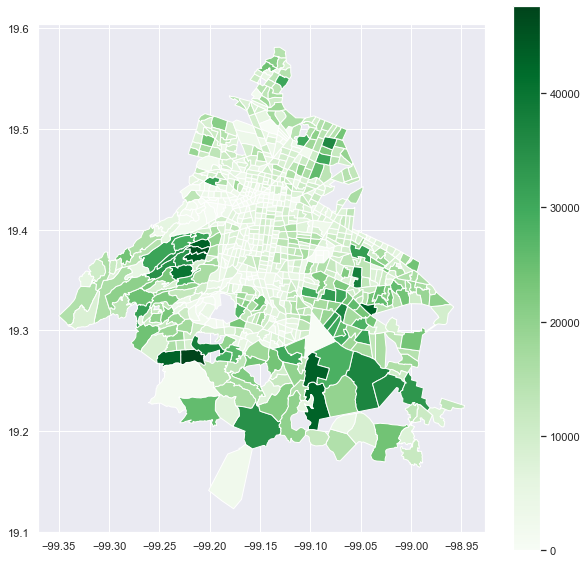

In [112]:
cuadrante_con_poblaciones.plot(column="POB1", legend=True, cmap="Greens")